# To delete

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Telecom/IMA205/TP4')
current_directory = os.getcwd()
print(current_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Telecom/IMA205/TP4


# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline.
Complete the code where you see XXXXXXXXXXXXXXXXX (mandatory for everybody)

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule).

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

## Prepartaions

### Importing necessary libraries

In [2]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools

### Defining utility functions

In [3]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


from sklearn.pipeline import make_pipeline

### Loading data

Then load the data from my Google Drive

In [4]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
dest_path='./data/features.csv')
gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
dest_path='./data/im/nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
dest_path='./data/im/nevus.jpg')
gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
dest_path='./data/im/melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data

In [5]:
## Read data
Working_directory="./data/"
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


### Data exploration

Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

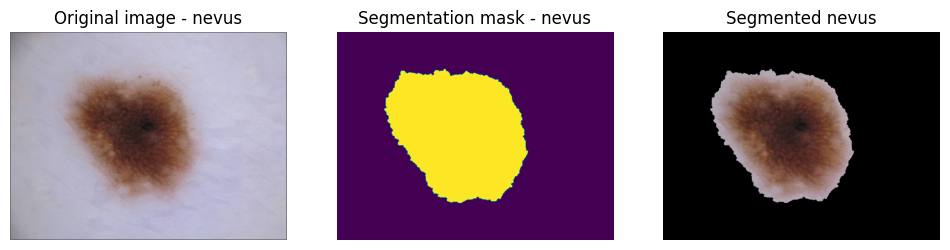

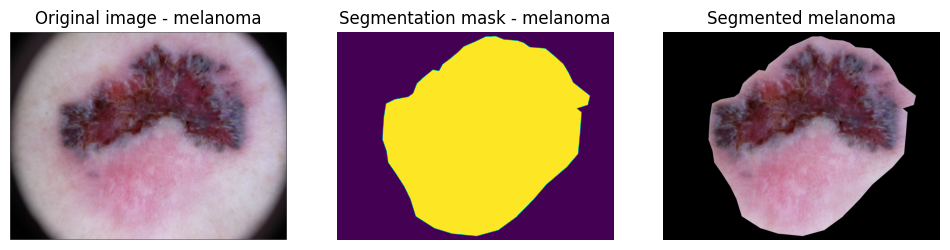

In [6]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg')
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg')
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


# Preprocessing

### Shuffiling data

Now, as in the previous practical session you should shuffle the data randomly

In [7]:
np.random.seed(42)
# Shuffle data randomly
indices=np.arange(len(X))
np.random.shuffle(indices)
Xp= X[indices]
yp= y[indices]

### Splitting and plotting histogram

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

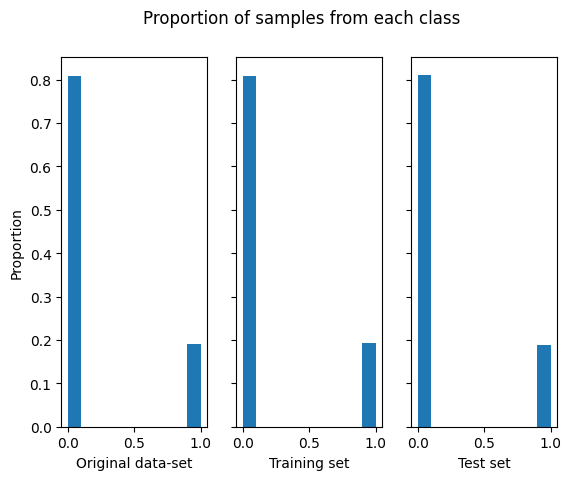

In [8]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

## Scaling

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ? (For simplicity's sake, we will restrict here to scaling all features).

**Answer**

In my opinion the right way to do it is to only consider the training set. Fit the standardscaler with it then transform the whole data with the obtained scaler.

No, we should not use together both training and test set.

In [9]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform (X_test)
print(f"The new data has mean = {np.round(X_train_scale.mean(axis=0),2)} and varaiance = {np.round(X_train_scale.var( axis= 0),2)}")

The new data has mean = [ 0.  0. -0. -0.  0.  0.  0. -0. -0.  0. -0. -0. -0. -0. -0.  0.  0.  0.
 -0. -0.  0.  0. -0. -0. -0. -0. -0.  0. -0. -0.] and varaiance = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


# Fitting classification models (LDA, QDA and KNN)

## Fitting LDA and QDA

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices.

**Question**: Comment the results.

**Answer**

By using the given features as they are, we obtain 0.82 accuracy. This may seem good at first since we are able to classify correctly the majority of the images. However, by looking into the confusion matrix we see that we have a bad model that predicts almost always healthy class. In fact, 71% of the unhealthy images are labeled as healthy. This is espacially very bad in the case of illness detection since the patient can be in danger and the model predicts that he is healthy which can lead to disasters.

#### LDA

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       146
           1       0.62      0.29      0.40        34

    accuracy                           0.83       180
   macro avg       0.74      0.63      0.65       180
weighted avg       0.81      0.83      0.81       180

Normalized confusion matrix
[[0.95890411 0.04109589]
 [0.70588235 0.29411765]]


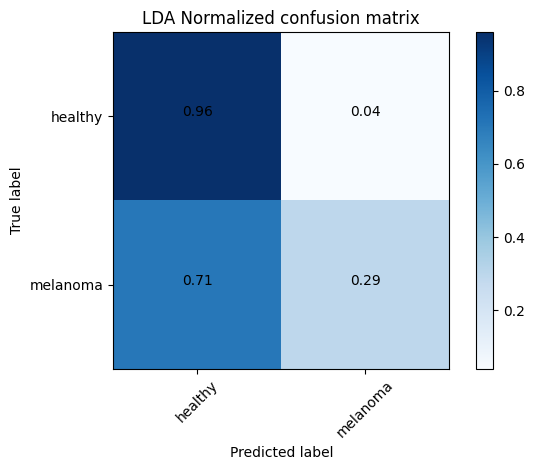

In [10]:
# Fitting LDA
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred = lda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()



#### QDA

Fitting LDA to train set
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       146
           1       0.53      0.24      0.33        34

    accuracy                           0.82       180
   macro avg       0.69      0.59      0.61       180
weighted avg       0.78      0.82      0.79       180

Normalized confusion matrix
[[0.95205479 0.04794521]
 [0.76470588 0.23529412]]


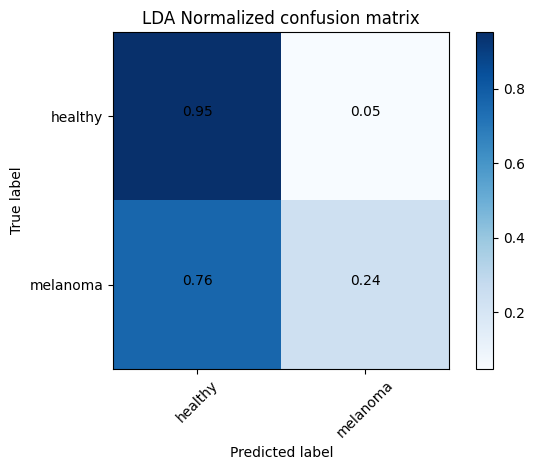

In [11]:
# Fitting QDA
print("Fitting LDA to train set")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scale,y_train)
y_pred = qda.predict(X_test_scale)
print(classification_report(y_test,y_pred))


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()


## Cross Validation on scaled LDA, QDA and KNN

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

We can use Cross validation in order to lower the estimation error caused by considering different kinds of data repartitions.

### LDA

In [12]:
# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=X, y=np.ravel(yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std()))




Fitting LDA
done in 0.112s
 Average and std CV score : 0.8 +- 0.005270462766947316


### QDA

In [13]:

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=X, y=np.ravel(yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))


Fitting QDA
done in 0.147s
 Average and std CV score : 0.6816666666666668 +- 0.021343747458109495


### KNN

In [14]:

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh =  make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
neigh_score = cross_val_score(neigh,X=X, y=np.ravel(yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting K-nearest neighbour
done in 0.378s
 Average and std CV score : 0.76 +- 0.020682789409984775


## Estimating K-NN parameter with cross-validation

---
When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation.

**Question** Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

---

Yes, We have almost always the same behaviour. We tend to classify everything in the healthy class (especially in the case of the non-healthy data). In my opinion, this is due to the nature of our data that is unbalanced. Thus giving the same importance throught the objectif function which is in our case the overall accuracy will yield good results overall at the cost of missclassifying some of the rare present data (the unhealthy images in our case)

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8261904761904763
Best training params: {'kneighborsclassifier__n_neighbors': 7}
Normalized confusion matrix
[[0.97945205 0.02054795]
 [0.79411765 0.20588235]]


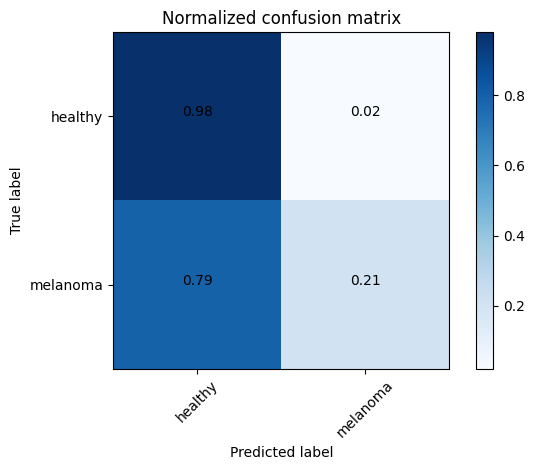

In [15]:
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Solution 1 : Estimating K-NN parameters with CrossValidation with a scoreing being the balanced-accuracy

In order to deal with this problem we have two possible solutions.

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.6068974978050922
Best training params: {'kneighborsclassifier__n_neighbors': 5}
Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.79411765 0.20588235]]


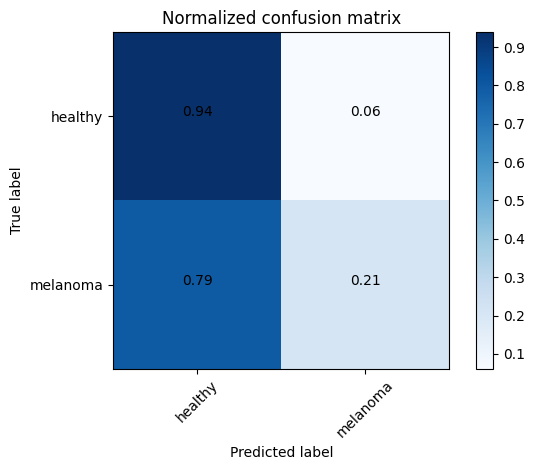

In [16]:
# Looking for the best hyperparameters

neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="balanced_accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Solution 2 : Estimating K-NN hyperparmeter with oversampling from the low occurrence class

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.org/stable/over_sampling.html) and try at least the ADASYN over-sampling strategy (look at the following code...).

NB: if you want to use the naive random oversampling (i.e. randomly sampling with replacement) be careful not to have the same sample both in the training and validation (or test) set during cross-validation (or testing). This would be considered as a data-leakage.

### Resampling using ADASYN

In [17]:
from imblearn.over_sampling import ADASYN
from collections import Counter
ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 328)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set.

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

Yes, The results are far better now. In fact we are able to almost predict every case of illness and we have a pretty good predictions on the healthy subjects

### Grid Cross Validation

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8485467399842891
Best training params: {'kneighborsclassifier__n_neighbors': 2}
Normalized confusion matrix
[[0.78082192 0.21917808]
 [0.52941176 0.47058824]]


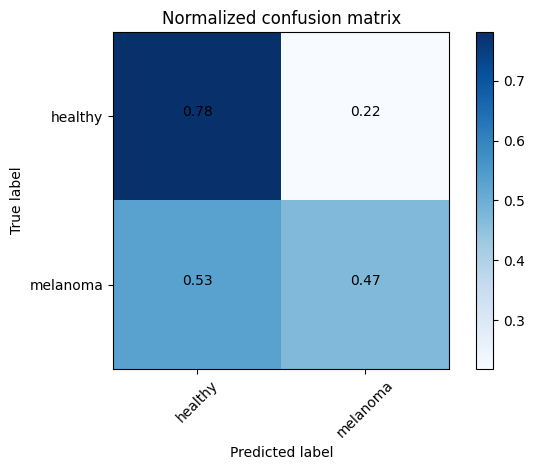

In [18]:
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())

# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_resampled_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_resampled_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

# Perceptron and Linear SVM

## Perceptron and Linear SVM on raw data

Let's use the techniques seen today: Perceptron and linear SVM.

In [19]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.7920833333333334 +- 0.032446537223219635
 Average and std TEST CV accuracy : 0.7733333333333333 +- 0.03704351795148813
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8404166666666667 +- 0.0076376261582597055
 Average and std TEST CV accuracy : 0.8166666666666667 +- 0.01748014746950254


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [20]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7920833333333334 +- 0.032446537223219635
 Average and std TEST CV accuracy : 0.7733333333333333 +- 0.03704351795148813
 Average and std TRAIN CV f1 : 0.32580839547081103 +- 0.08835977702696353
 Average and std TEST CV f1 : 0.2751282863477985 +- 0.11406450966266812
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8412499999999999 +- 0.0070217914776469405
 Average and std TEST CV accuracy : 0.8166666666666667 +- 0.01748014746950254
 Average and std TRAIN CV f1 : 0.41357138560320506 +- 0.04068338551835532
 Average and std TEST CV f1 : 0.3312736386420597 +- 0.0901562888956756


## Perceptron and Linear SVM on oversampled data

### Evaluating the results with Cross Validation (accuracy metric)

**Question** Please do the same on the oversampled data and compare the results with the previous ones. Please note that here you should use the ‘make_pipeline‘ function of Imbalanced scikit-learn. You can look here:  [LINK](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.make_pipeline.html)


**Answer**
As before we noitice a big improvement in classifiying the images in the test set when we over sample the lower class since it enables us to take it more into account in the model when training

In [21]:
from imblearn.pipeline import make_pipeline as make_pipeline2

# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp, cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Fitting Linear SVM
print("\n\nFitting Linear SVM")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
Perc_cv = cross_validate(Perc,Xp, yp, cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.67 +- 0.018474832731162787
 Average and std TEST CV accuracy : 0.6383333333333333 +- 0.03055050463303895
 Average and std TRAIN CV f1 : 0.4313567828314711 +- 0.02691261841655203
 Average and std TEST CV f1 : 0.370692920062179 +- 0.052948898493962226


Fitting Linear SVM
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7612499999999999 +- 0.009464847243000467
 Average and std TEST CV accuracy : 0.7150000000000001 +- 0.02999999999999997
 Average and std TRAIN CV f1 : 0.5268873602821429 +- 0.01674679247148894
 Average and std TEST CV f1 : 0.4365606535785654 +- 0.06523591049999762


### Evaluating the results with cross validation (accuracy , f1, confusion matrix)

We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data.
In that case, we will need to first split the data into train/test and then do the oversampling ONLY in the train data.

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6464285714285716 +- 0.037144001813863556
 Average and std TEST CV accuracy : 0.6023809523809525 +- 0.057636754461477153
 Average and std TRAIN CV f1 : 0.41301998227446857 +- 0.027224457863164485
 Average and std TEST CV f1 : 0.3706457532832483 +- 0.07335597917477431
Normalized confusion matrix
[[0.62328767 0.37671233]
 [0.29411765 0.70588235]]


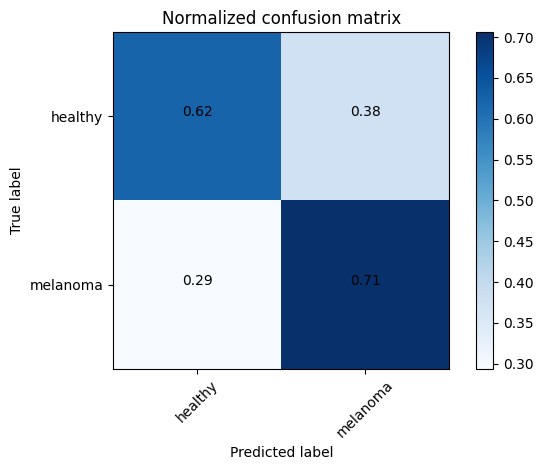

In [22]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()




Fitting Linear SVM
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7702380952380953 +- 0.020395049641680738
 Average and std TEST CV accuracy : 0.7214285714285714 +- 0.01428571428571428
 Average and std TRAIN CV f1 : 0.5344141889501601 +- 0.0327339893101041
 Average and std TEST CV f1 : 0.42266971777269263 +- 0.07317736716329169
Normalized confusion matrix
[[0.74657534 0.25342466]
 [0.47058824 0.52941176]]


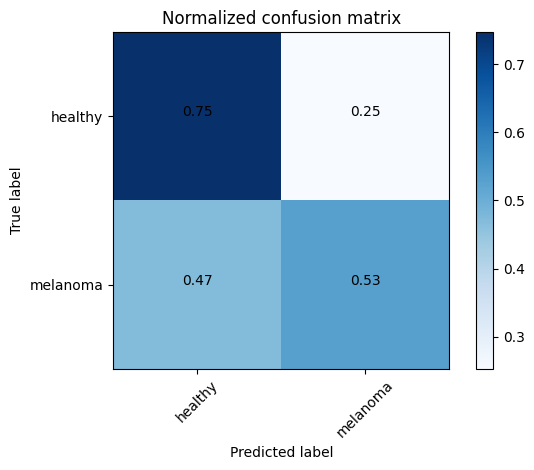

In [23]:

# Fitting linear SVM
print("Fitting Linear SVM")
SVM = make_pipeline2(ADASYN(random_state=0),StandardScaler(),LinearSVC())
SVM_cv = cross_validate(SVM,X_train,y_train,cv=5,scoring=('accuracy','f1'),return_train_score=True,return_estimator=True)
print(SVM_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(SVM_cv['train_accuracy'].mean(), SVM_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(SVM_cv['test_accuracy'].mean(), SVM_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(SVM_cv['train_f1'].mean(), SVM_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(SVM_cv['test_f1'].mean(), SVM_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(SVM_cv['test_accuracy'])
estimator_best=SVM_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()



## SVM with hyperparemeter C

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model.

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

Best training Score: 0.7428571428571429
Best training params: {'linearsvc__C': 0.01}
Normalized confusion matrix
[[0.74657534 0.25342466]
 [0.41176471 0.58823529]]


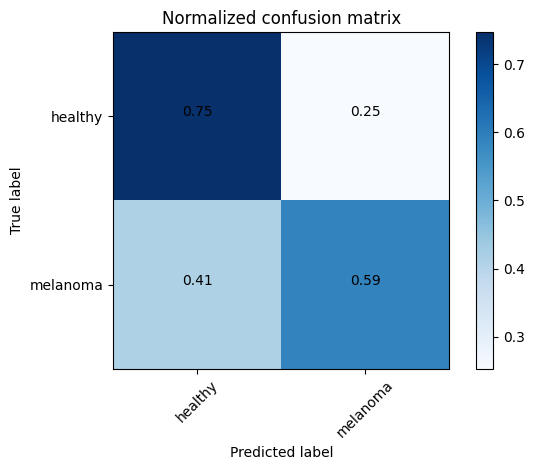

In [24]:
# Looking for the best hyperparameter C
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
grid_lsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

# Non-Linear SVM

## Non-Linear SVM with oversampled data

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best training Score: 0.8238095238095239
Best training params: {'svc__C': 0.1, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.97945205 0.02054795]
 [0.79411765 0.20588235]]


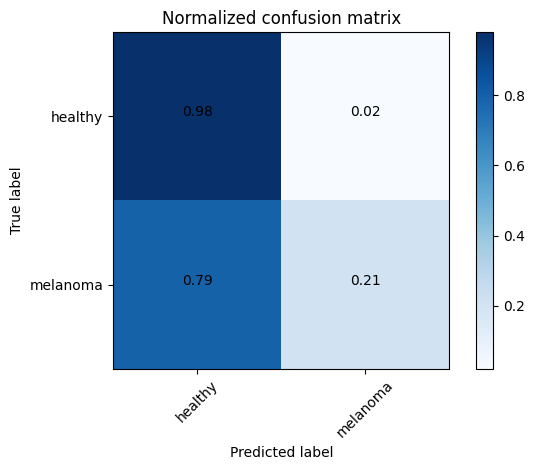

In [25]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), SVC(kernel='rbf'))
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator = NLsvm , param_grid =p_grid_nlsvm,scoring="accuracy",cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Non-Linear SVM on raw data with different scoring (strategy 1)

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

**Answer**

As can be seen in the confusion matrixes above, the changed metric doesn’t give us good results neither does the oversampled startegy. Comparing the matrix of the best training score, it seems that we are in a case of underfitting. In that case, changing the metric don’t seem to change the results. Thus having only this number of samples is not sufficient enough to get a good training leading to poor results as can be seen in the following cell

Fitting Non-linear SVM to the training set
Best training Score: 0.5973167251975418
Best training params: {'svc__C': 10.0, 'svc__gamma': 0.01}
Normalized confusion matrix
[[0.98630137 0.01369863]
 [0.82352941 0.17647059]]


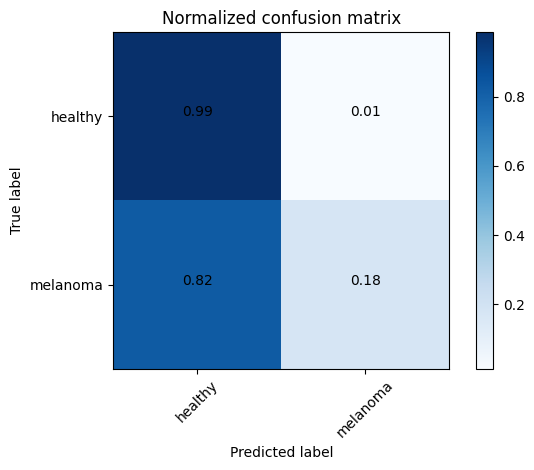

In [26]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(StandardScaler(), SVC(kernel='rbf'))
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator = NLsvm , param_grid =p_grid_nlsvm,scoring="balanced_accuracy",cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()



# Conclusion

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

To sum up, we have seen  different models with different strategies for dealing with the unbalanced classes issues. So far, the best method that gave me the best results is Linear SVM using the ADASYN resampling strategy and grid-corss-validation search for hyperparameter selection (hyperparameter C) alongside the accuracy metric (since now we have balanced classes with oversampling). The results were perticularly more accurate for the unhealthy class and yielded good accuracy overall.

I think it is worth it to oversample one of the two classes especially in cases like the one we are dealing with since this allows the model to better take the under-represented class into account even though it has rare occurances

# Optional Part

## Adding PCA to the pipeline

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

Best training Score: 0.7428571428571429
Best training params: {'linearsvc__C': 0.01}
Normalized confusion matrix
[[0.73972603 0.26027397]
 [0.47058824 0.52941176]]


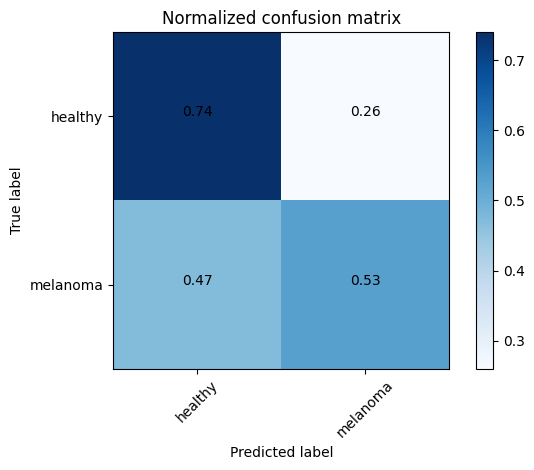

In [27]:
# Test PCA with a linear SVM

Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), PCA(n_components=0.95), LinearSVC())
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
grid_lsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas.

In [28]:
# Implement forward feature selection and/or backward feature selection
# with a linear SVM

#from sklearn.svm import SVC
np.random.seed(5)

from sklearn.metrics import f1_score

# Forward feature selection
def forward_feature_selection(X, y, stopping_criterion=None):
    n_features = X.shape[1]
    selected_features = []
    best_score = -1
    best_model = None
    #i=0
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    while len(selected_features) < n_features:
     #   i+=1
     #   print(f"curren step : {i}, selected_features = {selected_features}")
        best_feature = None
        for feature in range(n_features):
            if feature not in selected_features:
                candidate_features = selected_features + [feature]
                X_selected = X[:, candidate_features]

                model = LinearSVC()
                model.fit(X_train[:,candidate_features], y_train)
                y_pred = model.predict(X_test[:,candidate_features])
                score = f1_score(y_test, y_pred)

                if score >= best_score:
                    best_score = score
                    best_feature = feature
                    best_model = model

        if best_feature is not None:
            selected_features.append(best_feature)
            print("Selected Feature:", best_feature)
            print("F1 Score:", best_score)
        else:
            print("No more improvements, stopping feature selection.")
            break

        if stopping_criterion is not None and best_score >= stopping_criterion:
            print("Stopping criterion reached.")
            break

    return selected_features, best_model

# Forward feature selection
selected_features, best_model = forward_feature_selection(X_train, y_train)
print("Final selected features:", selected_features)


Selected Feature: 29
F1 Score: 0.35294117647058826
Selected Feature: 17
F1 Score: 0.375
Selected Feature: 25
F1 Score: 0.4
Selected Feature: 27
F1 Score: 0.4
Selected Feature: 28
F1 Score: 0.4
Selected Feature: 5
F1 Score: 0.5714285714285715
No more improvements, stopping feature selection.
Final selected features: [29, 17, 25, 27, 28, 5]


Normalized confusion matrix
[[0.84931507 0.15068493]
 [0.67647059 0.32352941]]


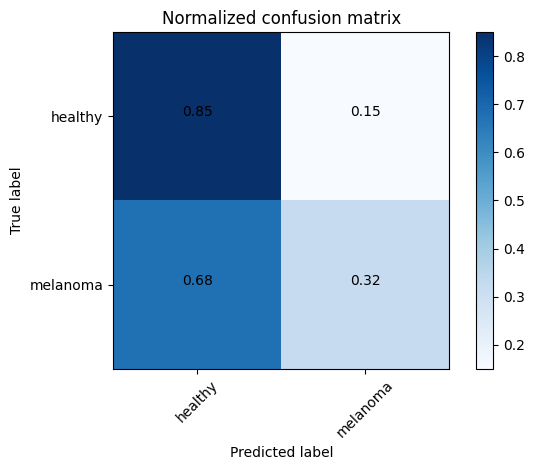

In [29]:
y_pred = best_model.predict(X_test[:,selected_features])

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()